# PROJECT-3. EDA + Feature Engineering

## 1. Импортируем библиотеки и загрузим данные.

In [70]:
# импортируем необходимые библиотеки
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import category_encoders as ce
from sklearn import preprocessing

# инструмент для анализа отзывов
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.downloader.download('vader_lexicon')

# Загружаем инструмент для разбивки данных:
from sklearn.model_selection import train_test_split  
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели 

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [71]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [72]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements_v3.txt

In [73]:
# Подгрузим наши данные для соревнования

INPUT_DIR = 'https://github.com/RuslanMavlitov/sf_data_science/raw/main/Project_3_EDA/'
df_train = pd.read_csv(INPUT_DIR+'/hotels_train.csv.zip') # датасет для обучения
df_test = pd.read_csv(INPUT_DIR+'hotels_test.csv.zip') # датасет для предсказания
sample_submission = pd.read_csv(INPUT_DIR+'/submission.csv.zip') # самбмишн

### Признаки

+ hotel_address - адрес отеля
+ review_date - дата, когда рецензент разместил соответствующий отзыв.
+ average_score - средний балл отеля, рассчитанный на основе последнего комментария за последний год
+ hotel_name - название отеля
+ reviewer_nationality - национальность рецензента
+ negative_review - отрицательный отзыв, который рецензент дал отелю.
+ review_total_negative_word_counts - общее количество слов в отрицательном отзыв
+ positive_review - положительный отзыв, который рецензент дал отелю
+ review_total_positive_word_counts - общее количество слов в положительном отзыве
+ reviewer_score - оценка, которую рецензент поставил отелю на основе своего опыта
+ total_number_of_reviews_reviewer_has_given - количество отзывов, которые рецензенты дали в прошлом
+ total_number_of_reviews - общее количество действительных отзывов об отеле
+ tags - теги, которые рецензент дал отелю.
+ days_since_review - продолжительность между датой проверки и датой очистки
+ additional_number_of_scoring - есть также некоторые гости, которые просто поставили оценку сервису, а не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки.
+ lat - широта отеля
+ lng - долгота отеля

In [74]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [75]:
df_train.head()

hotel_address  \
0  Stratton Street Mayfair Westminster Borough Lo...   
1  130 134 Southampton Row Camden London WC1B 5AF...   
2   151 bis Rue de Rennes 6th arr 75006 Paris France   
3  216 Avenue Jean Jaures 19th arr 75019 Paris Fr...   
4          Molenwerf 1 1014 AG Amsterdam Netherlands   

   additional_number_of_scoring review_date  average_score  \
0                           581   2/19/2016            8.4   
1                           299   1/12/2017            8.3   
2                            32  10/18/2016            8.9   
3                            34   9/22/2015            7.5   
4                           914    3/5/2016            8.5   

                                  hotel_name reviewer_nationality  \
0                         The May Fair Hotel      United Kingdom    
1            Mercure London Bloomsbury Hotel      United Kingdom    
2          Legend Saint Germain by Elegancia               China    
3  Mercure Paris 19 Philharmonie La Villette      United Kingdom    
4                Golden Tulip Amsterdam West              Poland    

       negative_review  review_total_negative_word_counts  \
0             Leaving                                   3   
1       poor breakfast                                  3   
2   No kettle in room                                   6   
3          No Negative                                  0   
4         Torn sheets                                   4   

   total_number_of_reviews                                    positive_review  \
0                     1994                                 Staff were amazing   
1                     1361                                           location   
2                      406                                        No Positive   
3                      607   Friendly staff quiet comfortable room spotles...   
4                     7586   The staff was very friendly and helpful Break...   

   review_total_positive_word_counts  \
0                                  4   
1                                  2   
2                                  0   
3                                 11   
4                                 20   

   total_number_of_reviews_reviewer_has_given  reviewer_score  \
0                                           7            10.0   
1                                          14             6.3   
2                                          14             7.5   
3                                           8            10.0   
4                                          10             9.6   

                                                tags days_since_review  \
0  [' Leisure trip ', ' Couple ', ' Studio Suite ...           531 day   
1  [' Business trip ', ' Couple ', ' Standard Dou...           203 day   
2  [' Leisure trip ', ' Solo traveler ', ' Modern...           289 day   
3  [' Leisure trip ', ' Solo traveler ', ' Standa...           681 day   
4  [' Business trip ', ' Couple ', ' Standard Dou...           516 day   

         lat       lng  
0  51.507894 -0.143671  
1  51.521009 -0.123097  
2  48.845377  2.325643  
3  48.888697  2.394540  
4  52.385601  4.847060

In [76]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [77]:
df_test.head(3)

hotel_address  \
0                 Via Senigallia 6 20161 Milan Italy   
1  Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...   
2        Mallorca 251 Eixample 08008 Barcelona Spain   

   additional_number_of_scoring review_date  average_score  \
0                           904   7/21/2017            8.1   
1                           612  12/12/2016            8.6   
2                            46  11/26/2015            8.3   

                                   hotel_name reviewer_nationality  \
0                              Hotel Da Vinci      United Kingdom    
1                           Urban Lodge Hotel             Belgium    
2  Alexandra Barcelona A DoubleTree by Hilton              Sweden    

                                     negative_review  \
0   Would have appreciated a shop in the hotel th...   
1        No tissue paper box was present at the room   
2                                           Pillows    

   review_total_negative_word_counts  total_number_of_reviews  \
0                                 52                    16670   
1                                 10                     5018   
2                                  3                      351   

                                     positive_review  \
0   Hotel was great clean friendly staff free bre...   
1                                        No Positive   
2                         Nice welcoming and service   

   review_total_positive_word_counts  \
0                                 62   
1                                  0   
2                                  5   

   total_number_of_reviews_reviewer_has_given  \
0                                           1   
1                                           7   
2                                          15   

                                                tags days_since_review  \
0  [' Leisure trip ', ' Couple ', ' Double Room '...           13 days   
1  [' Leisure trip ', ' Group ', ' Triple Room ',...           234 day   
2  [' Business trip ', ' Solo traveler ', ' Twin ...           616 day   

         lat       lng  
0  45.533137  9.171102  
1  52.385649  4.834443  
2  41.393192  2.161520

In [78]:
sample_submission.head()

reviewer_score      id
0               1  488440
1              10  274649
2               3  374688
3              10  404352
4               9  451596

In [79]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


In [80]:
# Для корректной обработки признаков объединяем train и test в один датасет
df_train['sample'] = 1 # помечаем тренировочную выборку
df_test['sample'] = 0 # помечаем тестовую выборку
df_test['reviewer_score'] = 0 # в test у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

data = pd.concat(
    [df_train, df_test], 
    ignore_index=True
)
data.head(3)

hotel_address  \
0  Stratton Street Mayfair Westminster Borough Lo...   
1  130 134 Southampton Row Camden London WC1B 5AF...   
2   151 bis Rue de Rennes 6th arr 75006 Paris France   

   additional_number_of_scoring review_date  average_score  \
0                           581   2/19/2016            8.4   
1                           299   1/12/2017            8.3   
2                            32  10/18/2016            8.9   

                          hotel_name reviewer_nationality  \
0                 The May Fair Hotel      United Kingdom    
1    Mercure London Bloomsbury Hotel      United Kingdom    
2  Legend Saint Germain by Elegancia               China    

       negative_review  review_total_negative_word_counts  \
0             Leaving                                   3   
1       poor breakfast                                  3   
2   No kettle in room                                   6   

   total_number_of_reviews      positive_review  \
0                     1994   Staff were amazing   
1                     1361             location   
2                      406          No Positive   

   review_total_positive_word_counts  \
0                                  4   
1                                  2   
2                                  0   

   total_number_of_reviews_reviewer_has_given  reviewer_score  \
0                                           7            10.0   
1                                          14             6.3   
2                                          14             7.5   

                                                tags days_since_review  \
0  [' Leisure trip ', ' Couple ', ' Studio Suite ...           531 day   
1  [' Business trip ', ' Couple ', ' Standard Dou...           203 day   
2  [' Leisure trip ', ' Solo traveler ', ' Modern...           289 day   

         lat       lng  sample  
0  51.507894 -0.143671       1  
1  51.521009 -0.123097       1  
2  48.845377  2.325643       1

In [81]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

## 2. EDA
### Работа с пропусками

In [82]:
# для предварительного анализа используем Pandas-profiling
from pandas_profiling import ProfileReport
profile = ProfileReport(data, title="Info about booking hotels")
profile

Summarize dataset:   0%|          | 0/5 [00:04<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### Из предоставленных данных можно сделать несколько выводов:
+ в колонках 'lat' и 'lng' есть 6536 пропусков
+ в датасете присутствуют 336 дубликатов
+ между признаками 'additional_number_of_scoring' и 'total_number_of_reviews' наблюдается сильная корреляция

In [83]:
# для удобства заполнения пропусков в признаках lat и lng извлечём признаки страны и города из признака hotel_address  
data['hotel_country'] = data['hotel_address'].apply(lambda x: 'United Kingdom' if x.split()[-1]=='Kingdom' else x.split()[-1])
data['hotel_city'] = data['hotel_address'].apply(lambda x: x.split()[-5] if x.split()[-1]=='Kingdom' else x.split()[-2])

In [84]:
# получим список уникальных городов в которых содержатся пропуски
lat_mask = data['lat'].isnull()
lng_mask = data['lng'].isnull()


In [85]:
null_city = list(set(data[lat_mask]['hotel_city']))

display(f'Количество уникальных значений городов, для которых обнаружены пропуски: {len(null_city)}')
print(null_city)

'Количество уникальных значений городов, для которых обнаружены пропуски: 3'

['Barcelona', 'Paris', 'Vienna']


In [86]:
# удалим исходный признак hotel_address
data.drop('hotel_address', axis=1, inplace=True)

In [87]:
# создадим словарь с модальными значениями координат по каждому городу с пропусками в данных
lat_dict = {}
lng_dict = {}

for city in null_city:
    lat_dict[city] = lat_dict.get(city, data[data['hotel_city']==city]['lat'].mode()[0])
    lng_dict[city] = lng_dict.get(city, data[data['hotel_city']==city]['lng'].mode()[0])

In [88]:
# заполняем пропуски в lat и lng модальными значениями для конкретного города
for city in null_city:
    data.loc[(lat_mask & (data['hotel_city'] == city)), 'lat'] = lat_dict[city]
    data.loc[(lng_mask & (data['hotel_city'] == city)), 'lng'] = lng_dict[city]

In [89]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 19 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   review_date                                 515738 non-null  object 
 2   average_score                               515738 non-null  float64
 3   hotel_name                                  515738 non-null  object 
 4   reviewer_nationality                        515738 non-null  object 
 5   negative_review                             515738 non-null  object 
 6   review_total_negative_word_counts           515738 non-null  int64  
 7   total_number_of_reviews                     515738 non-null  int64  
 8   positive_review                             515738 non-null  object 
 9   review_total_positive_word_counts           515738 non-null  int64  
 

### Создание новых признаков

In [90]:
# добавим признаки населения страны (country_population), населения города (city_population)
# и долю людей, проживающих в городе от общего кол-ва нареления страны (city_to_country_share)
country_population = {
    'United Kingdom':67_108_596,
    'Spain':47_344_649,
    'France':67_413_000,
    'Netherlands':17_645_800,
    'Austria':9_027_999,
    'Italy':59_257_566
    }

city_population = {
    'London':8_961_989,
    'Barcelona':1_636_732,
    'Paris':2_148_327,
    'Amsterdam':872_757,
    'Vienna':1_897_491,
    'Milan':1_378_689
    }

data['country_population'] = data['hotel_country'].map(country_population)
data['city_population'] = data['hotel_city'].map(city_population)
data['city_to_country_share'] = data['city_population'] / data['country_population'] 

In [91]:
# из признака даты извлечём месяц, когда был составлен отзыв
data['review_date'] = pd.to_datetime(data['review_date'])
data['review_month'] = data['review_date'].dt.month

# удалим исходный признак
data.drop('review_date', axis=1, inplace=True)

In [92]:
# анализируем отзывы пользователей с помощью библиотеки nltk
sent_analyzer = SentimentIntensityAnalyzer()

data['positive_rev_score'] = data['positive_review'].apply(lambda x: sent_analyzer.polarity_scores(x))
data['negative_rev_score'] = data['negative_review'].apply(lambda x: sent_analyzer.polarity_scores(x))

# под каждую оценку создадим отдельный признак
data.loc[:,['p_neg', 'p_neu', 'p_pos', 'p_compound']] = list(data['positive_rev_score'].apply(lambda x: [x['neg'], x['neu'], x['pos'], x['compound']]).values)
data.loc[:,['n_neg', 'n_neu', 'n_pos', 'n_compound']] = list(data['negative_rev_score'].apply(lambda x: [x['neg'], x['neu'], x['pos'], x['compound']]).values)

# удалим исходный признаки
data.drop(['positive_review', 'negative_review', 
           'positive_rev_score', 'negative_rev_score'], axis=1, inplace=True)

In [93]:
# выполним анализ тегов
tags_dict = {} 

def unique_tags(tags_list):
    tags_list = tags_list[3:-3].split(" ', ' ")
    for tag in tags_list:
        tags_dict[tag] = tags_dict.get(tag, 0) + 1
        

data['tags'].apply(unique_tags)

len(tags_dict)

2428

In [94]:
# выведем топ 20 самых популярных тегов
top15_uniq_tags = pd.DataFrame(tags_dict, index=['count']).transpose().sort_values(by='count', ascending=False)[:20]
top15_uniq_tags

count
Leisure trip                    417778
Submitted from a mobile device  307640
Couple                          252294
Stayed 1 night                  193645
Stayed 2 nights                 133937
Solo traveler                   108545
Stayed 3 nights                  95821
Business trip                    82939
Group                            65392
Family with young children       61015
Stayed 4 nights                  47817
Double Room                      35207
Standard Double Room             32248
Superior Double Room             31393
Family with older children       26349
Deluxe Double Room               24823
Double or Twin Room              22393
Stayed 5 nights                  20845
Standard Double or Twin Room     17483
Classic Double Room              16989

In [95]:
# закодируем признак tags
for tag in list(top15_uniq_tags.index):
    data[tag] = data['tags'].apply(lambda x: 1 if tag in x else 0)

In [96]:
# удалим исходный признак
data.drop('tags', axis=1, inplace=True)

In [97]:
# работа со странами рецензентов
top10_countries = data['reviewer_nationality'].value_counts()[:10]
top10_countries

 United Kingdom               245246
 United States of America      35437
 Australia                     21686
 Ireland                       14827
 United Arab Emirates          10235
 Saudi Arabia                   8951
 Netherlands                    8772
 Switzerland                    8678
 Germany                        7941
 Canada                         7894
Name: reviewer_nationality, dtype: int64

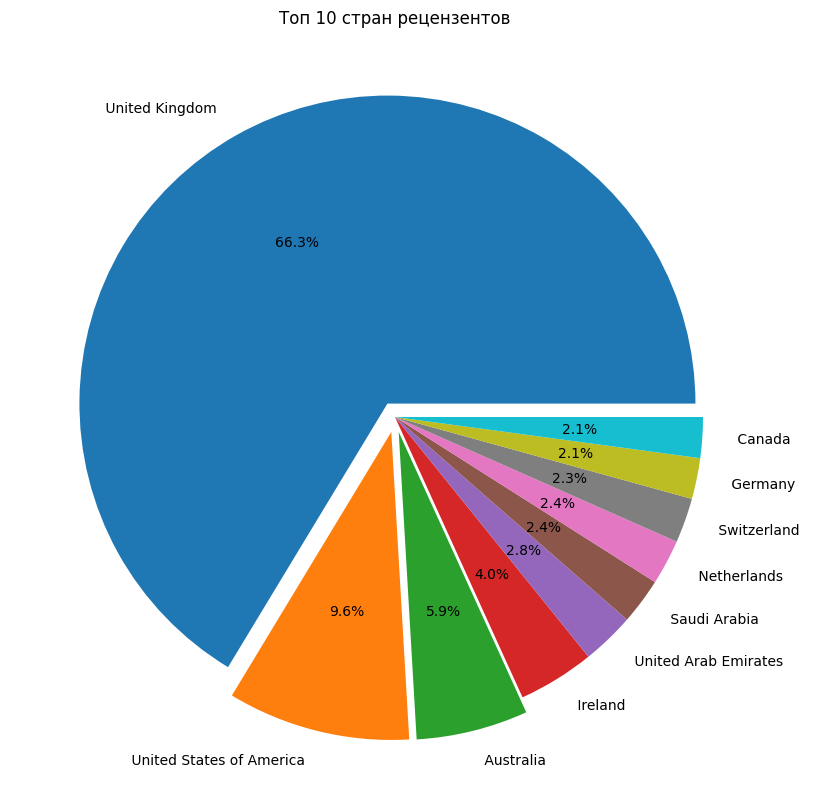

In [98]:
fig, ax = plt.subplots(figsize = (10, 10))

ax.pie(
    top10_countries,
    labels = top10_countries.index,
    autopct='%.1f%%',
    explode = [0.05, 0.05, 0.05, 0, 0, 0, 0, 0, 0, 0]
)
fig.patch.set_facecolor('white')
ax.set_title('Топ 10 стран рецензентов')

plt.show()

In [99]:
data['reviewer_nationality'] = data['reviewer_nationality'].apply(lambda x: x if x in top10_countries.index else 'other')

In [100]:
# оставим только число в признаке days_since_review
data['days_since_review'] = data['days_since_review'].apply(lambda x: int(x.split()[0]))

### Отбор признаков

In [101]:
# признак hotel_name не получится использовать для получения полезной информации,  поэтому избавимся от него
data.drop('hotel_name', axis=1, inplace=True)

In [102]:
object_columns = [x for x in data.columns if data[x].dtypes == 'object']
object_columns

['reviewer_nationality', 'hotel_country', 'hotel_city']

In [103]:
# оценим оставшиеся признаки типа object
display(data['reviewer_nationality'].unique())
display(data['hotel_country'].unique())
display(data['hotel_city'].unique())

array([' United Kingdom ', 'other', ' Switzerland ',
       ' United Arab Emirates ', ' United States of America ',
       ' Netherlands ', ' Ireland ', ' Canada ', ' Germany ',
       ' Australia ', ' Saudi Arabia '], dtype=object)

array(['United Kingdom', 'France', 'Netherlands', 'Italy', 'Austria',
       'Spain'], dtype=object)

array(['London', 'Paris', 'Amsterdam', 'Milan', 'Vienna', 'Barcelona'],
      dtype=object)

In [104]:
# закодируем признаки типа object при помощи двоичного кодирования
data = pd.get_dummies(data, columns=object_columns)

In [105]:
# выполним нормализацию данных методом RobustScaler

# Копируем названия столбцов, которые теряются при использовании fit_transform()
col_names = list(data.columns)

# инициализируем нормализатор RobustScaler
r_scaler = preprocessing.RobustScaler()

# копируем исходный датасет
data_r = r_scaler.fit_transform(data)

# Преобразуем промежуточный датасет в полноценный датафрейм для визуализации
data_r = pd.DataFrame(data, columns=col_names)

In [106]:
data_r.describe()

additional_number_of_scoring  average_score  \
count                 515738.000000  515738.000000   
mean                     498.081836       8.397487   
std                      500.538467       0.548048   
min                        1.000000       5.200000   
25%                      169.000000       8.100000   
50%                      341.000000       8.400000   
75%                      660.000000       8.800000   
max                     2682.000000       9.800000   

       review_total_negative_word_counts  total_number_of_reviews  \
count                      515738.000000            515738.000000   
mean                           18.539450              2743.743944   
std                            29.690831              2317.464868   
min                             0.000000                43.000000   
25%                             2.000000              1161.000000   
50%                             9.000000              2134.000000   
75%                            23.000000              3613.000000   
max                           408.000000             16670.000000   

       review_total_positive_word_counts  \
count                      515738.000000   
mean                           17.776458   
std                            21.804185   
min                             0.000000   
25%                             5.000000   
50%                            11.000000   
75%                            22.000000   
max                           395.000000   

       total_number_of_reviews_reviewer_has_given  reviewer_score  \
count                               515738.000000   515738.000000   
mean                                     7.166001        6.297672   
std                                     11.040228        3.902295   
min                                      1.000000        0.000000   
25%                                      1.000000        0.625000   
50%                                      3.000000        7.900000   
75%                                      8.000000        9.600000   
max                                    355.000000       10.000000   

       days_since_review            lat            lng  ...  \
count      515738.000000  515738.000000  515738.000000  ...   
mean          354.441932      49.432405       2.893527  ...   
std           208.928124       3.460258       4.667536  ...   
min             0.000000      41.328376      -0.369758  ...   
25%           175.000000      48.214662      -0.143372  ...   
50%           353.000000      51.499981       0.019886  ...   
75%           527.000000      51.516288       4.841163  ...   
max           730.000000      52.400181      16.429233  ...   

       hotel_country_Italy  hotel_country_Netherlands  hotel_country_Spain  \
count        515738.000000              515738.000000        515738.000000   
mean              0.072143                   0.110936             0.116627   
std               0.258725                   0.314053             0.320976   
min               0.000000                   0.000000             0.000000   
25%               0.000000                   0.000000             0.000000   
50%               0.000000                   0.000000             0.000000   
75%               0.000000                   0.000000             0.000000   
max               1.000000                   1.000000             1.000000   

       hotel_country_United Kingdom  hotel_city_Amsterdam  \
count                 515738.000000         515738.000000   
mean                       0.508594              0.110936   
std                        0.499927              0.314053   
min                        0.000000              0.000000   
25%                        0.000000              0.000000   
50%                        1.000000              0.000000   
75%                        1.000000              0.000000   
max                        1.000000              1.000000   

       hotel_city_Barcelona  hotel_city_London  hotel_city

In [107]:
list(data_r.columns)

['additional_number_of_scoring',
 'average_score',
 'review_total_negative_word_counts',
 'total_number_of_reviews',
 'review_total_positive_word_counts',
 'total_number_of_reviews_reviewer_has_given',
 'reviewer_score',
 'days_since_review',
 'lat',
 'lng',
 'sample',
 'country_population',
 'city_population',
 'city_to_country_share',
 'review_month',
 'p_neg',
 'p_neu',
 'p_pos',
 'p_compound',
 'n_neg',
 'n_neu',
 'n_pos',
 'n_compound',
 'Leisure trip',
 'Submitted from a mobile device',
 'Couple',
 'Stayed 1 night',
 'Stayed 2 nights',
 'Solo traveler',
 'Stayed 3 nights',
 'Business trip',
 'Group',
 'Family with young children',
 'Stayed 4 nights',
 'Double Room',
 'Standard Double Room',
 'Superior Double Room',
 'Family with older children',
 'Deluxe Double Room',
 'Double or Twin Room',
 'Stayed 5 nights',
 'Standard Double or Twin Room',
 'Classic Double Room',
 'reviewer_nationality_ Australia ',
 'reviewer_nationality_ Canada ',
 'reviewer_nationality_ Germany ',
 'review

In [108]:
num_cols = [
    'additional_number_of_scoring', 'review_total_negative_word_counts', 
    'total_number_of_reviews', 'review_total_positive_word_counts',
    'total_number_of_reviews_reviewer_has_given', 'days_since_review', 
    'country_population', 'city_population', 'city_to_country_share', 
    'p_neg', 'p_neu', 'p_pos', 'p_compound', 'n_neg', 'n_neu', 'n_pos', 
    'n_compound'
    ]

cat_cols = [
    'average_score', 'lat', 'review_month', 
    'Leisure trip', 'Submitted from a mobile device', 'Couple', 'Stayed 1 night',
    'Stayed 2 nights', 'Solo traveler', 'Stayed 3 nights', 'Business trip',
    'Group', 'Family with young children', 'Stayed 4 nights', 'Double Room',
    'Standard Double Room', 'Superior Double Room',
    'Family with older children', 'Deluxe Double Room',
    'Double or Twin Room', 'Stayed 5 nights',
    'Standard Double or Twin Room', 'Classic Double Room',
    'reviewer_nationality_ Australia ', 'reviewer_nationality_ Canada ', 
    'reviewer_nationality_ Germany ', 'reviewer_nationality_ Ireland ', 
    'reviewer_nationality_ Netherlands ', 'reviewer_nationality_ Saudi Arabia ',
    'reviewer_nationality_ Switzerland ',
    'reviewer_nationality_ United Arab Emirates ',
    'reviewer_nationality_ United Kingdom ',
    'reviewer_nationality_ United States of America ',
    'reviewer_nationality_other', 'hotel_country_Austria',
    'hotel_country_France', 'hotel_country_Italy',
    'hotel_country_Netherlands', 'hotel_country_Spain',
    'hotel_country_United Kingdom', 'hotel_city_Amsterdam',
    'hotel_city_Barcelona', 'hotel_city_London', 'hotel_city_Milan',
    'hotel_city_Paris', 'hotel_city_Vienna'
    ]

In [112]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей)  
train_data = data_r.query('sample == 1').drop(['sample'], axis=1)
test_data = data_r.query('sample == 0').drop(['sample'], axis=1)

X = train_data.drop(['reviewer_score'], axis=1)
y = train_data.reviewer_score.values

# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.  
# Для тестирования мы будем использовать 20% от исходного датасета.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [113]:
from sklearn.feature_selection import f_classif # anova

<AxesSubplot:>

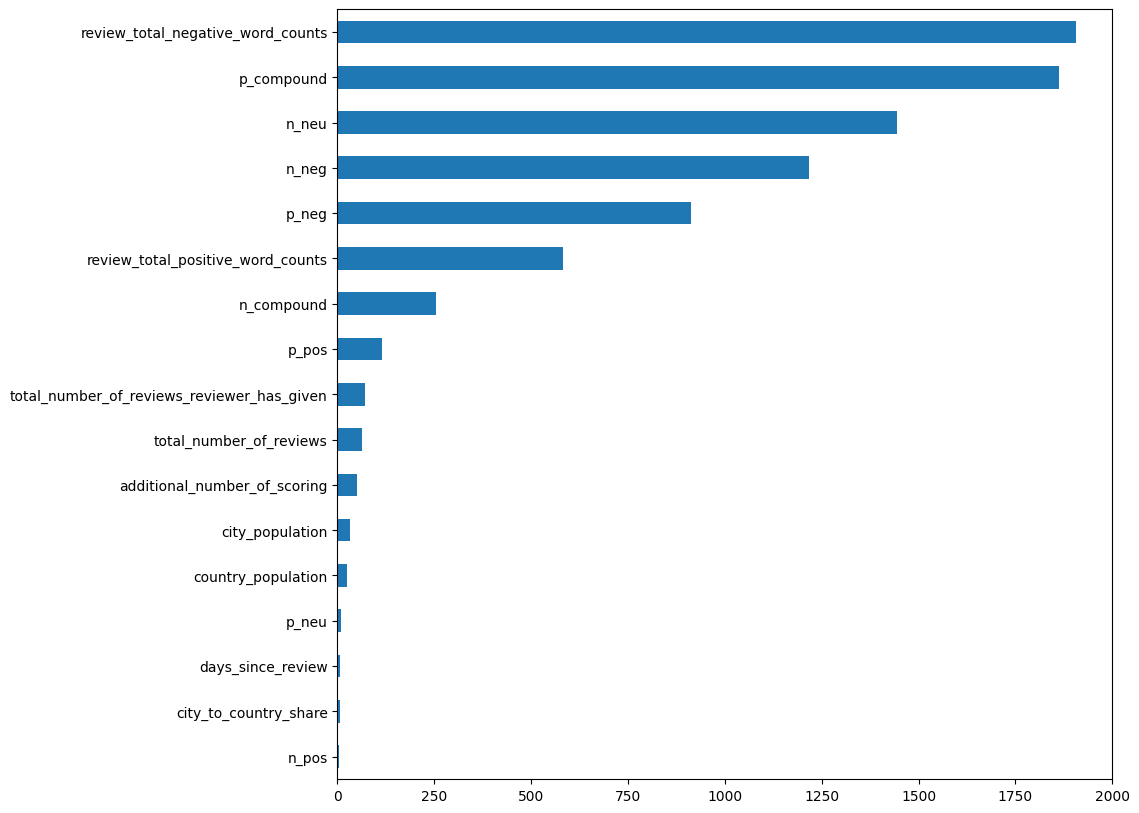

In [114]:
plt.rcParams['figure.figsize'] = (10,10)
imp_num = pd.Series(f_classif(X[num_cols], y)[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

In [115]:
del_columns = ['n_pos', 'city_to_country_share', 'days_since_review', 'p_neu']

<AxesSubplot:>

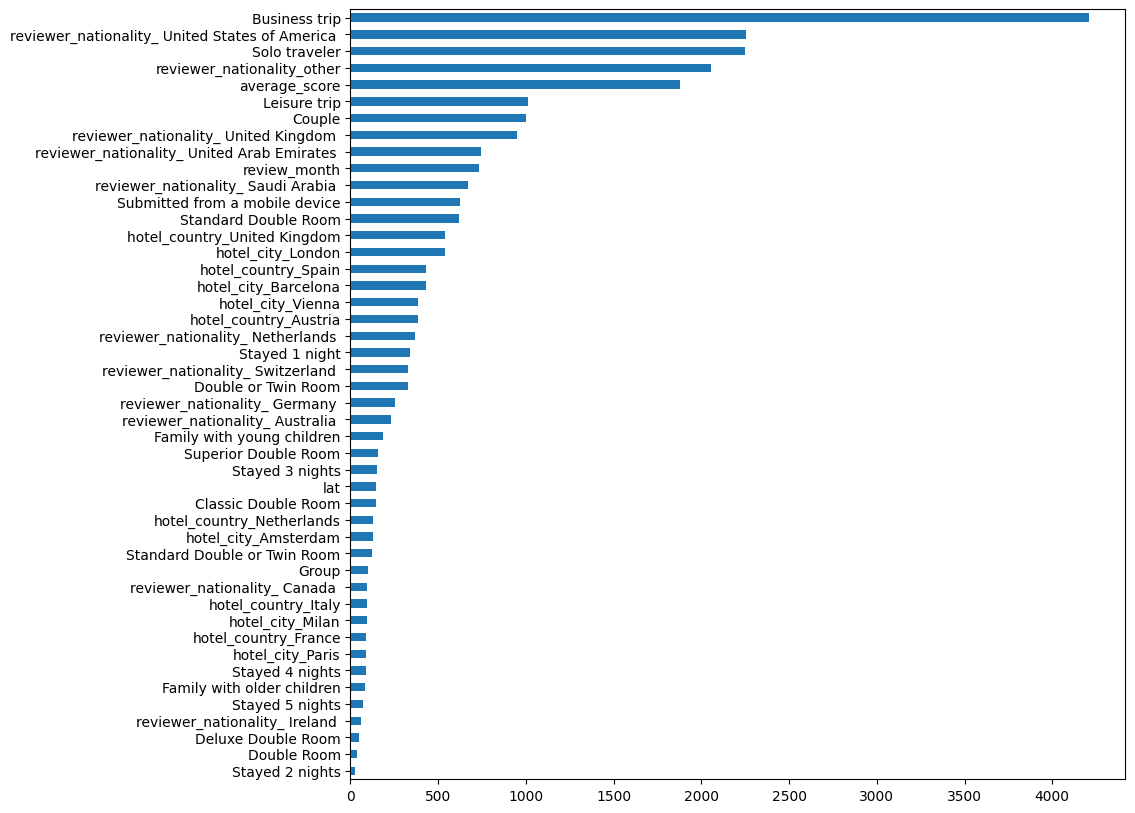

In [116]:
from sklearn.feature_selection import chi2 # хи-квадрат

y=y.astype('int')
imp_cat = pd.Series(chi2(X[cat_cols], y)[0], index=cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh');

In [117]:
# поиск мультиколлениарности
pivot = data_r.corr()
pivot = pivot.drop('sample', axis=0)
pivot = pivot.drop('sample', axis=1)

for col in pivot:
    pivot[col] = pivot[col].apply(lambda x: np.nan if (abs(x) < 0.7 or x == 1) else x)
    
for col in pivot:
    pivot = pivot.dropna(how='all')
    pivot = pivot.dropna(how='all', axis=1)

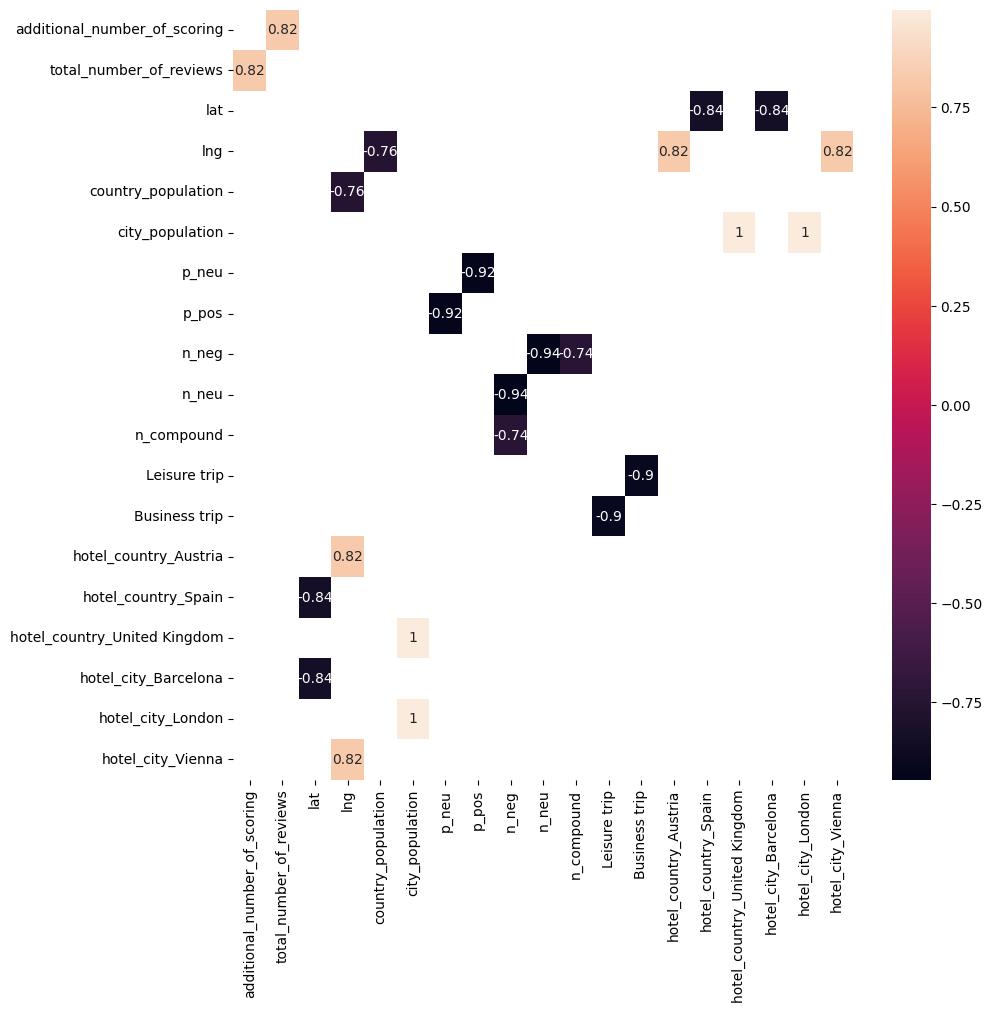

In [118]:
plt.rcParams['figure.figsize'] = (10,10)
sns.heatmap(pivot, annot=True);

In [119]:
del_columns.extend(['additional_number_of_scoring', 'lat', 'lng', 'city_population', 'n_neg', 'Leisure trip'])

In [120]:
# удалим колонки, не прошедшие отбор
data_r.drop(del_columns, axis=1, inplace=True)

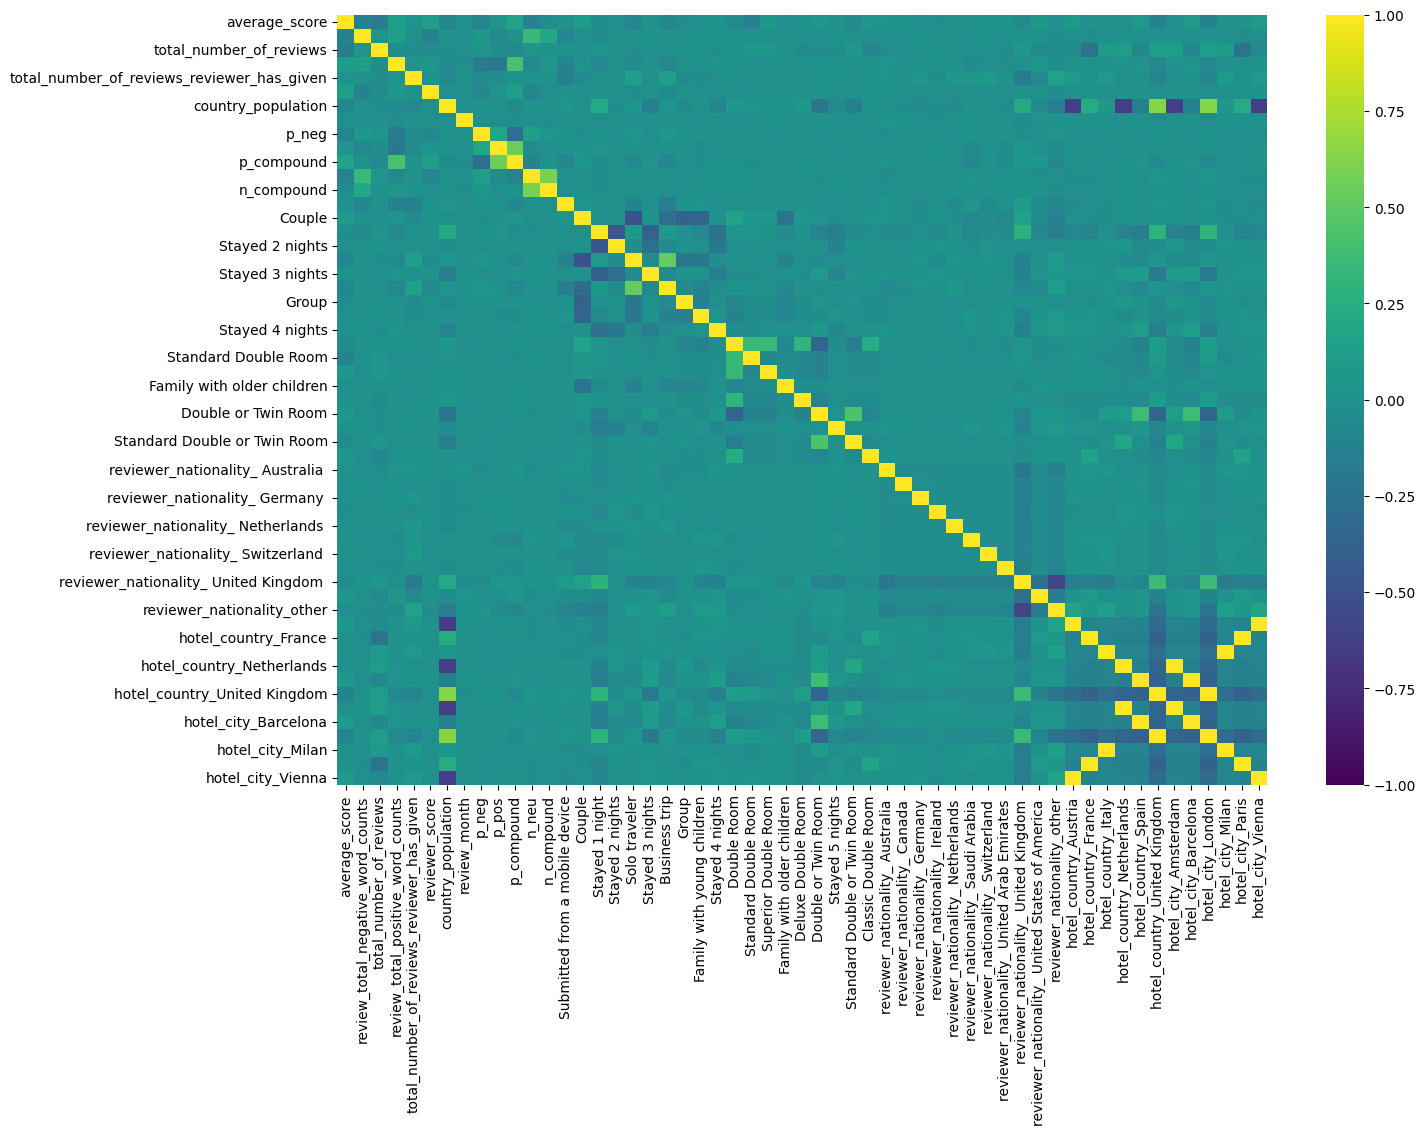

In [121]:
# Проверим корреляцию между признаками
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data_r.drop(['sample'], axis=1).corr(), cmap='viridis', vmin=-1, vmax=1, center= 0, fmt='.1g');

## 3. ML
### Подготовка данных для модели

In [122]:
train_data = data_r.query('sample == 1').drop(['sample'], axis=1)
test_data = data_r.query('sample == 0').drop(['sample'], axis=1)

X = train_data.drop(['reviewer_score'], axis=1)
y = train_data.reviewer_score.values

In [123]:
# разделяем тренинговый датасет: 80% на обучение, 20% на валидацию
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [124]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 55), (386803, 55), (386803, 54), (309442, 54), (77361, 54))

In [125]:
# создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
regr = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

# Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train) 

# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.8min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   19.8s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:   22.0s finished


In [126]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.  
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.12494298226505428


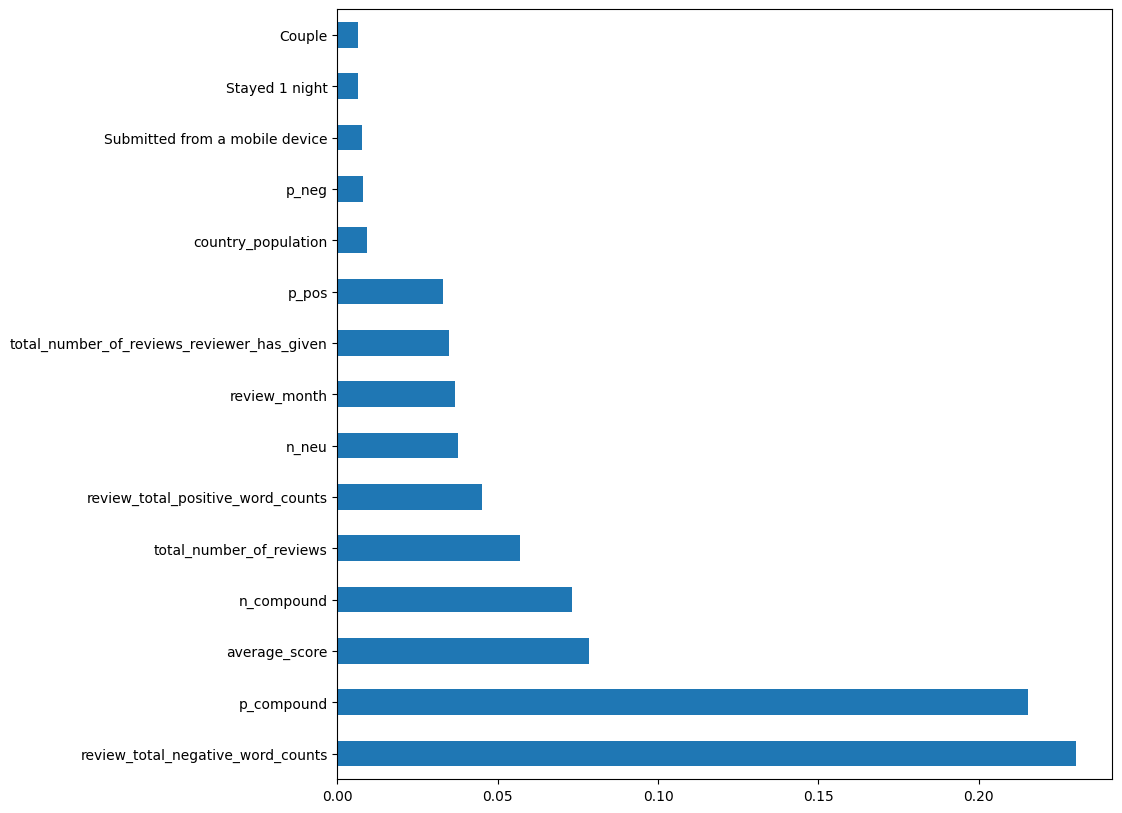

In [127]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(regr.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh');

In [128]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [129]:
sample_submission.head(3)

reviewer_score      id
0               1  488440
1              10  274649
2               3  374688

In [130]:
predict_submission = regr.predict(test_data)
predict_submission

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    5.6s finished


array([8.635, 7.158, 8.976, ..., 8.449, 9.455, 7.048])

In [131]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('data/submission_v3.csv', index=False)
sample_submission.head(10)

reviewer_score      id
0           8.635  488440
1           7.158  274649
2           8.976  374688
3           9.740  404352
4           9.476  451596
5           9.060  302161
6           8.181  317079
7           7.432   13963
8           8.385  159785
9           7.588  195089